# [Exploration 9] 캐글 경진대회 보스턴 집값 예측 프로젝트

이번 프로젝트는 2019년 kaggle에서 ........

## 1. 데이터셋 준비

### 1. (1) 필요한 모듈 준비

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import missingno as msno

import os
from os.path import join

import pandas as pd
import numpy as np


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb

import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

프로젝트를 진행하는데 필요한 모듈을 먼저 쭉 `import`해준다.

### 1. (2) 데이터 디렉토리 경로 설정

In [18]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('🦁️')

🦁️


## 2. 데이터 전처리

train set과 test set의 데이터를 먼저 확인해본다.

In [19]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [20]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 2. (1) 불필요한 데이터 정리

id는 가격을 예측하는데 필요하지 않으므로 제거해주고 (train과 test 둘다에서),   
date는 현재 string type으로 되어있으므로 int로 변경함과 동시에 YYYYMM형태로 남겨준다.

In [21]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del train['id']
del test['id']

train.head()
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### 2. (2) target label 설정

In [22]:
y = train['price']
del train['price']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


train데이터에서 **price**를 y변수에 할당하여 label로 사용한다.   
(test 데이터셋에는 처음부터 target값이 포함되어있지 않음!)

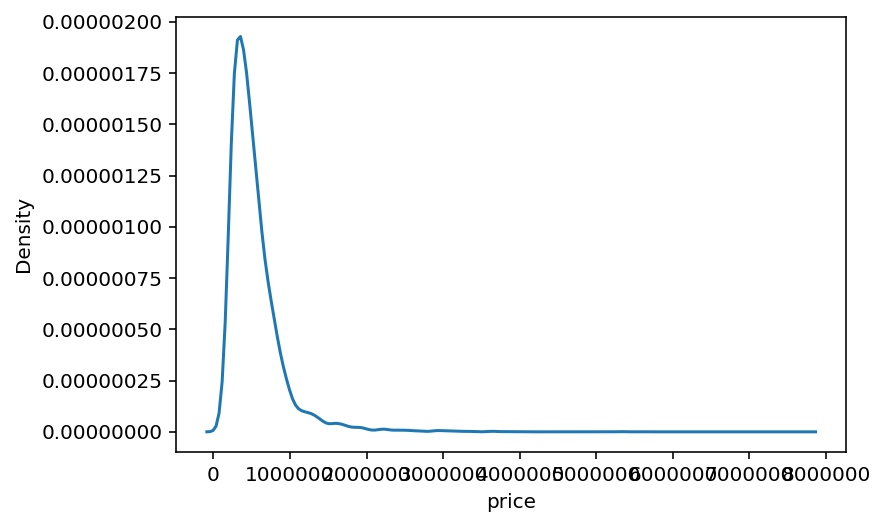

In [23]:
sns.kdeplot(y)
plt.show()

### 2. (3) 데이터 정규화 하기

In [24]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

print(len(data))

21503


데이터를 정규화 하기 위해서 먼저 train set과 test set을 하나로 합쳐준다.   
이후 원래 length에 맞게 분리해주기 위해서 train_len의 변수를 만들어 길이를 확인해둔다.

### * 결측치 확인

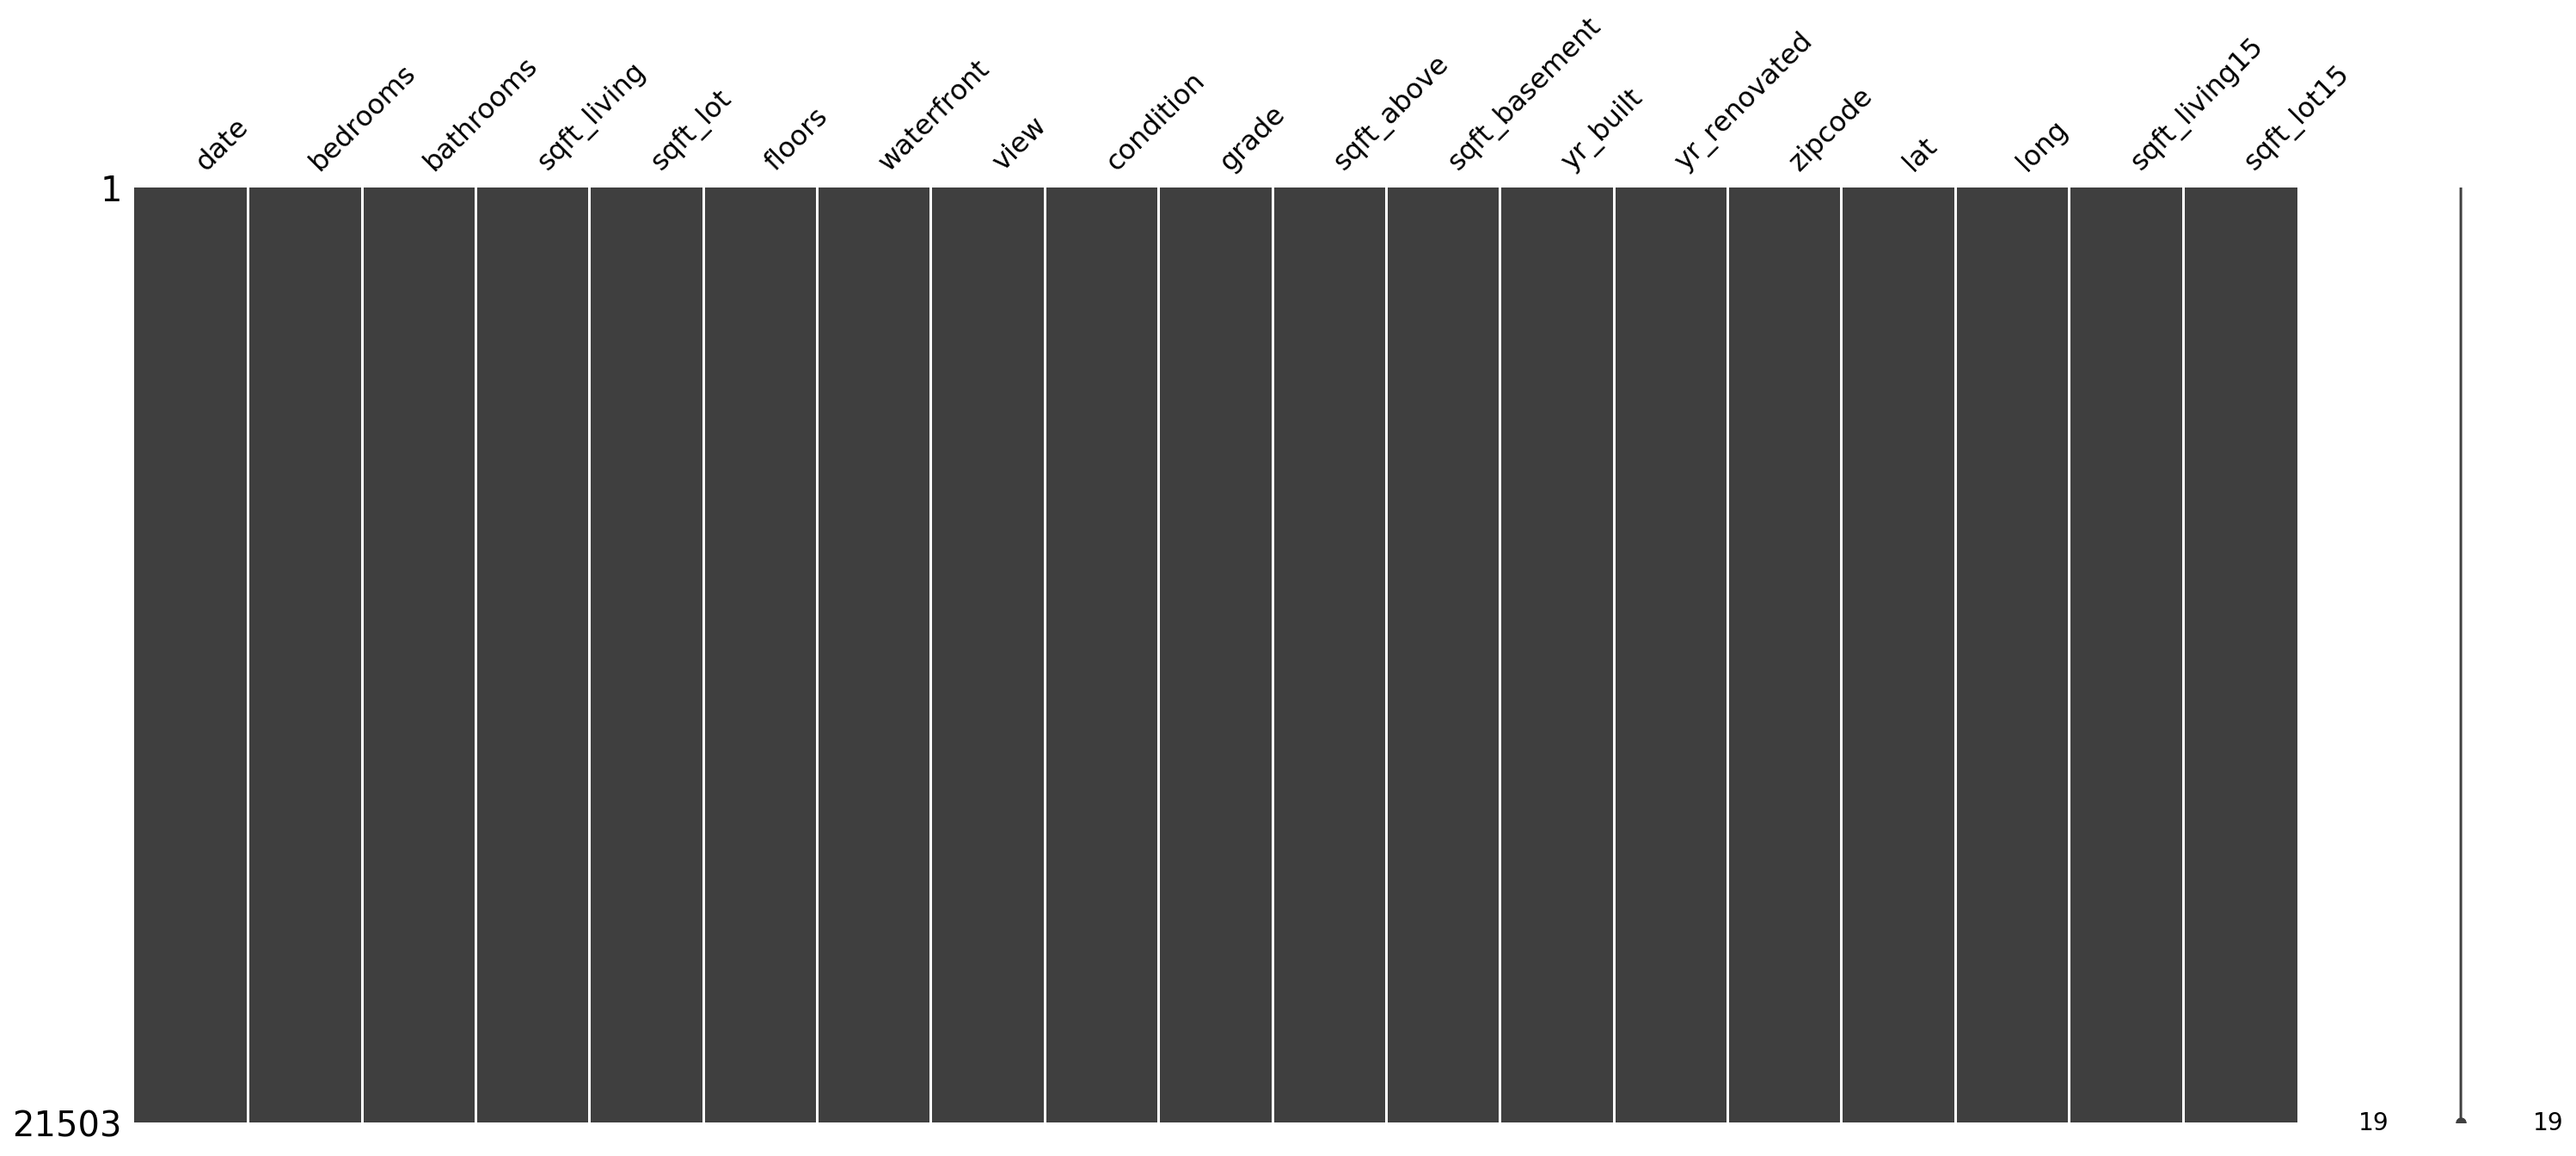

In [25]:
msno.matrix(data)

`missingno` 라이브러리를 활용해서 결측치를 확인해본다.   
기존에는 총 21개의 컬럼값이 있었는데 id와 price를 제거하여 총 19개의 값이 확인된다.   
(흰색으로 나와있는 부분이 결측치라고 볼 수 있는데 현재는 없는 것으로 확인된다.)

In [26]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


수치로 확인해봐도 결측치가 없는 것을 확인할 수 있다.

### * 데이터 분포 확인

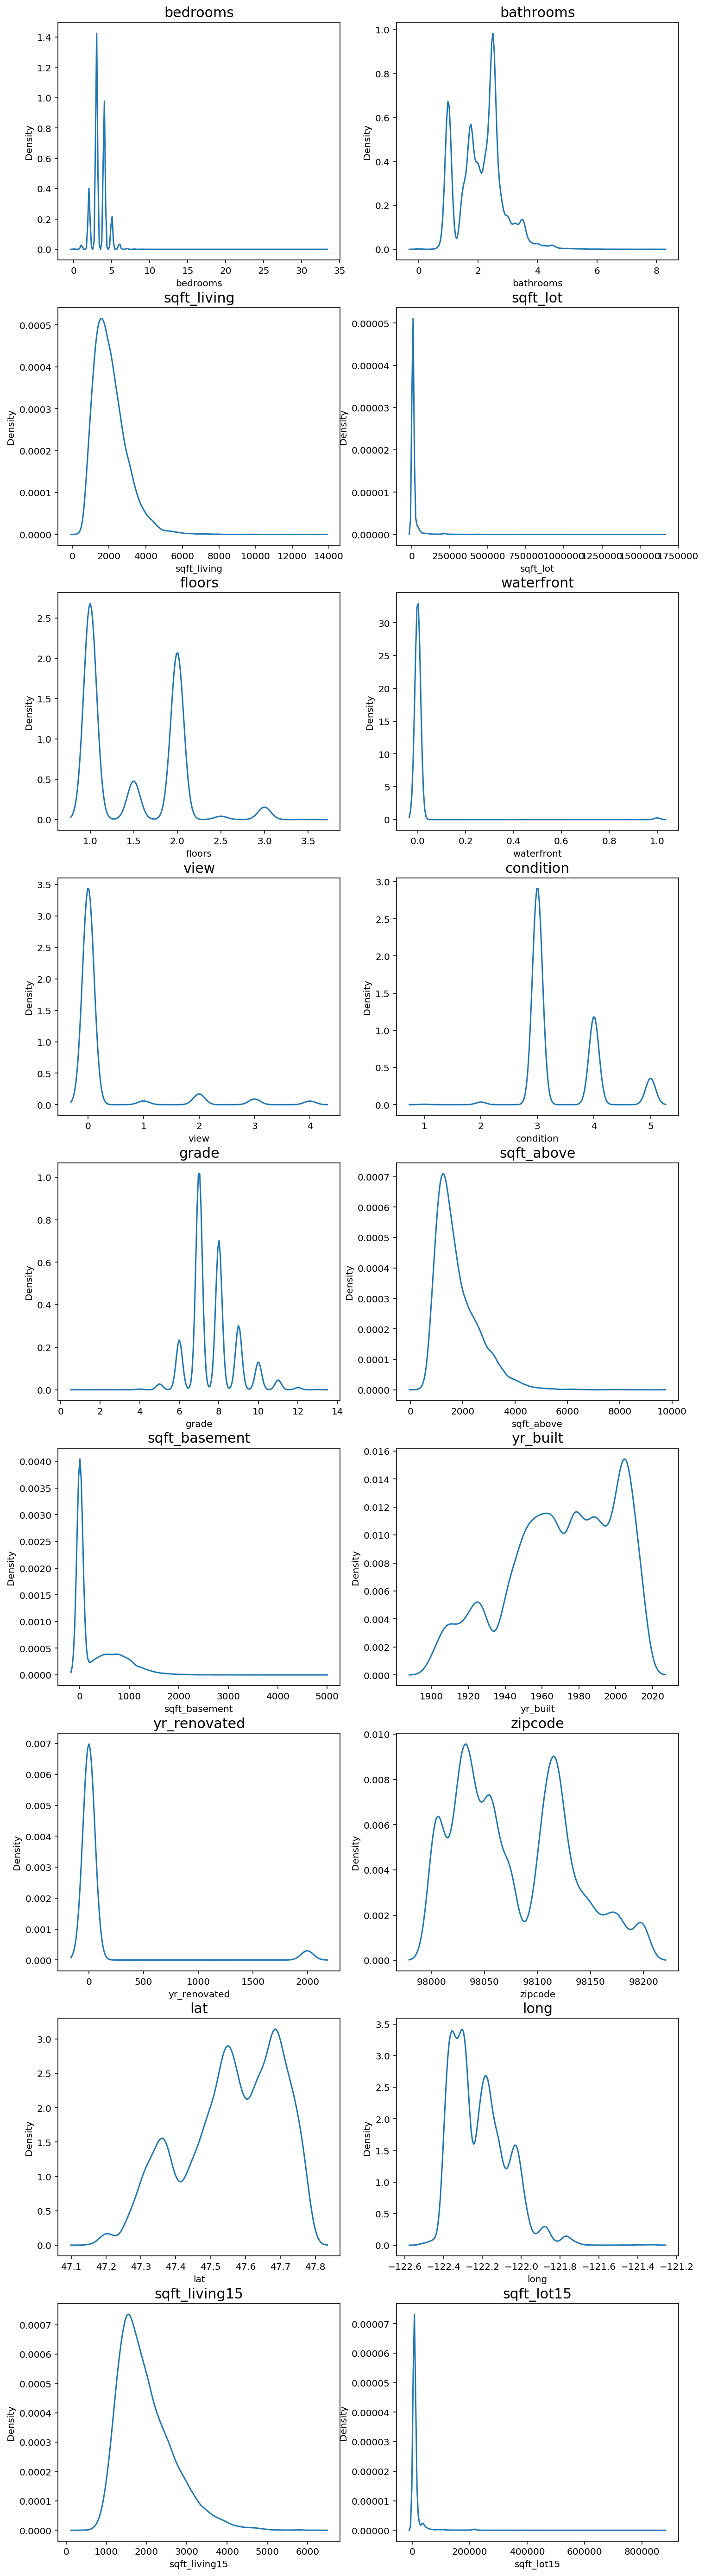

In [27]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

데이터를 그래프로 확인해본 결과, 아래와 같은 값에서 한쪽으로 치우친 분포를 확인할 수 있다.    
(bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 총 5가지!)

### 여기서 한가지 배울 수 있는 점은,  
데이터에 결측치가 없다고 문제가 없는 것이 아니라는 점이다. 그래프를 통해 데이터를 확인해본 결과 한쪽으로 치우쳐저 있는 데이터는 학습시에 영향을 미칠 수 있으므로 꼭 눈으로 확인 후 정규분포를 확인하여 학습하는 것이 성능에 더 좋은 영향을 미칠 것으로 확인된다.

In [28]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

print('🦁️')

🦁️


정규분포를 위해서 log함수를 사용하여 해준다.   
이는 log함수의 특징을 잘 나타내는데, 로그는 좁은 범위에 조밀하게 모여있는 값들을 넓게 펼칠 수 있고, 넓은 범위에 있는 값들은 좁은 범위로 모아줄 수 있는 특징이 있기 때문이다.   
로그 그래프는 아래와 같이 확인할 수 있다.

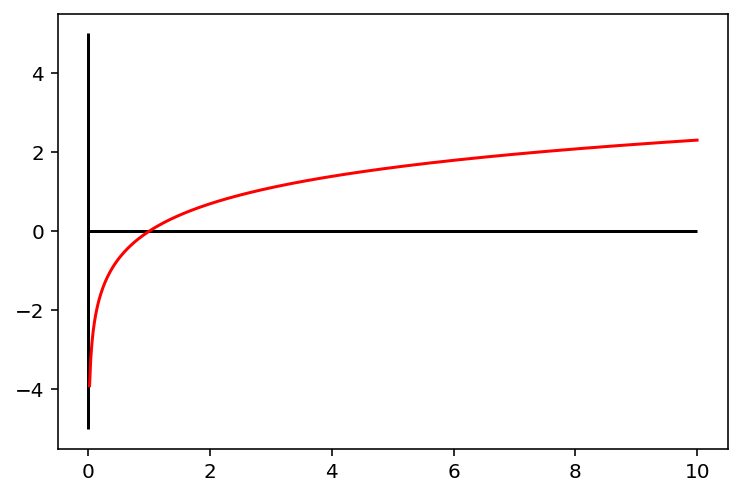

In [29]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

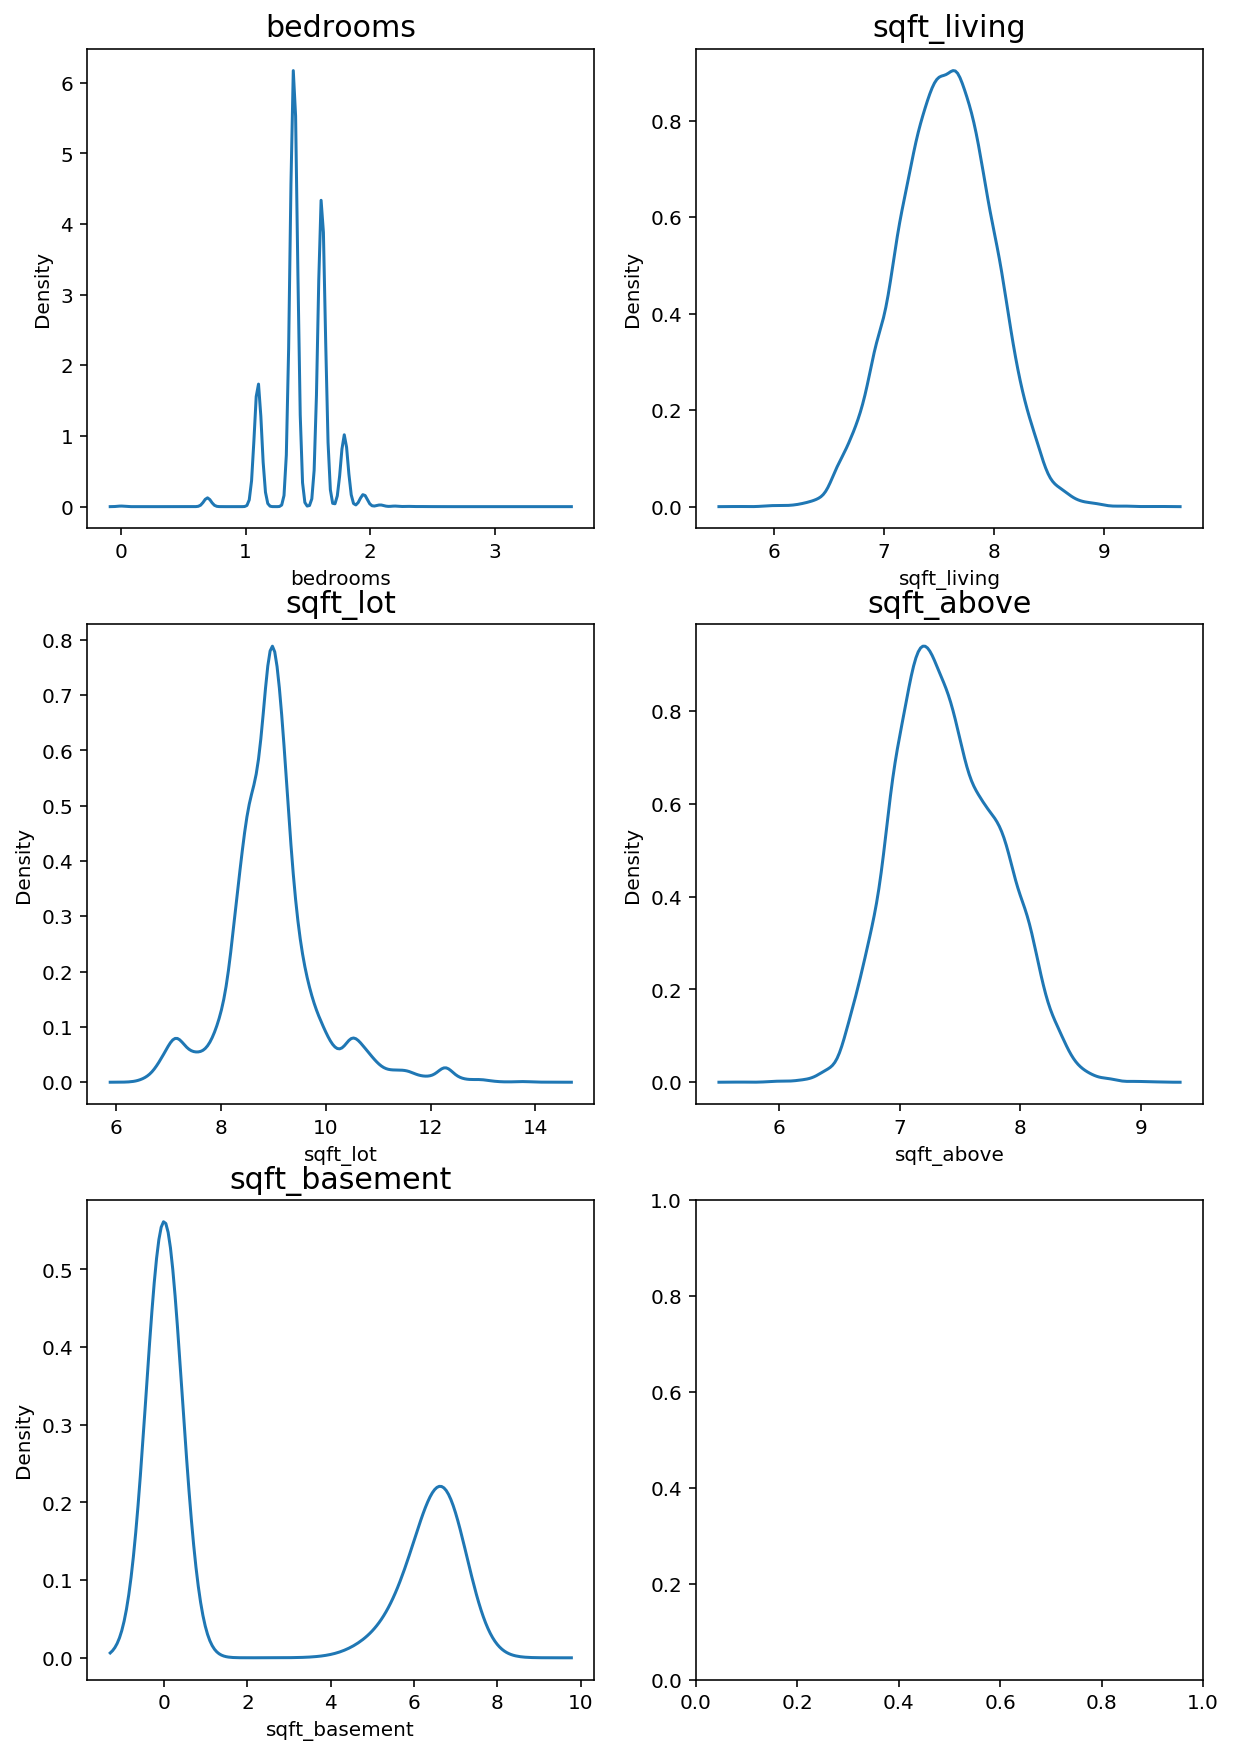

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1

정규분포된 값들을 확인해볼 수 있다 :)

동일한 방법으로 target값도 정규분포를 실행해준다.

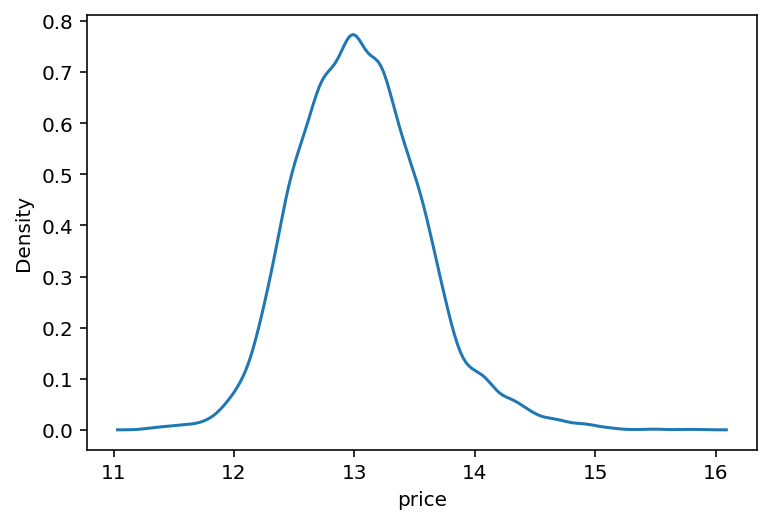

In [31]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

## train, test 데이터 분리

데이터 전처리를 완료 하였으니, 다시 train 데이터셋과 test 데이터셋을 분리해준다.

In [32]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


## 3. 모델 설정 & RSME 값 구하기

## 3. (1) RMSE 계산

필요한 모듈 import

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### RMSE 구하는 함수 정의

In [34]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))
    #np.sqrt는 루트, mean_squared_error는 실제값에서 예측값을 빼서 제곱한것
    #위 둘을 평균 낸것이 RMSE

print('🦁️')

🦁️


## 3. (2) 모델 설정

In [35]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('🦁️')

🦁️


모델은 총 4가지 GradientBoostingRegressor, XGBRegressor, LGBMRegressor, RandomForestRegressor을 사용한다.   
각 모델을 일정한 random state값을 설정하여 변수로 설정해주고, `models`라는 list 형태로 넣어준다.   
`models`는 이후에 각 모델별로 for문을 사용하여 학습할 예정이다.

In [36]:
def get_scores(models, train, y):

    df = {}
    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
        model.fit(X_train, y_train)
    
    # 예측
        y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

In [37]:
get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.173766
RandomForestRegressor,125325.083751
LGBMRegressor,111906.947718
XGBRegressor,110319.301793


df라는 빈 딕셔너리를 생성한 후, 각각의 RMSE값을 딕셔너리에 key = model_name, value = RMSE 값으로 설정하여 넣어준다.   
score_df는 pandas의 DataFrame형태로 transpose하여 만들어준다.

## 4. Grid Search를 사용하여 최적의 하이퍼 파라미터 찾아보기

필요한 모듈 import

In [38]:
from sklearn.model_selection import GridSearchCV

GridSearch에 사용되는 파라미터들은 다음과 같다.   

    param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    scoring : 모델의 성능을 평가할 지표
    cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수


In [44]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'learing_rate' : [0.0001, 0.001, 0.01, 0.1]
}

In [45]:
model = LGBMRegressor(random_state=random_state)

In [46]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.4s
[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:   13.4s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'learing_rate': [0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [10, 15, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [47]:
grid_model.cv_results_

{'mean_fit_time': array([0.18857288, 0.30723934, 0.44587059, 0.19854088, 0.32509327,
        0.45713358, 0.20116849, 0.33071008, 0.43512797, 0.17379994,
        0.31518164, 0.46004443, 0.19138923, 0.32498555, 0.41775222,
        0.19597254, 0.33552575, 0.44671965, 0.18633509, 0.29740033,
        0.4078187 , 0.19083896, 0.32794552, 0.45187569, 0.19894052,
        0.32892299, 0.44010277, 0.19163208, 0.31057334, 0.41642022,
        0.16543579, 0.32502704, 0.44371829, 0.19531298, 0.32805357,
        0.45137682]),
 'std_fit_time': array([0.00781997, 0.01524479, 0.01995231, 0.00963581, 0.01824313,
        0.02775488, 0.01352254, 0.02424268, 0.01964159, 0.03613783,
        0.02953498, 0.02433454, 0.00384436, 0.02235225, 0.0649025 ,
        0.00745412, 0.02299795, 0.01183248, 0.01700246, 0.03753484,
        0.05913766, 0.0274749 , 0.01568412, 0.02253933, 0.0080608 ,
        0.00410689, 0.02683671, 0.00780821, 0.03046328, 0.06151958,
        0.03287961, 0.02158851, 0.02852054, 0.00492039, 0.007

In [55]:
params = grid_model.cv_results_['params']
params[:5]

[{'learing_rate': 0.0001, 'max_depth': 10, 'n_estimators': 100},
 {'learing_rate': 0.0001, 'max_depth': 10, 'n_estimators': 200},
 {'learing_rate': 0.0001, 'max_depth': 10, 'n_estimators': 300},
 {'learing_rate': 0.0001, 'max_depth': 15, 'n_estimators': 100},
 {'learing_rate': 0.0001, 'max_depth': 15, 'n_estimators': 200}]

In [56]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02702383, -0.02618647, -0.02612638, -0.02717233, -0.02636361,
       -0.02626987, -0.02704872, -0.02624421, -0.02609125, -0.02702383,
       -0.02618647, -0.02612638, -0.02717233, -0.02636361, -0.02626987,
       -0.02704872, -0.02624421, -0.02609125, -0.02702383, -0.02618647,
       -0.02612638, -0.02717233, -0.02636361, -0.02626987, -0.02704872,
       -0.02624421, -0.02609125, -0.02702383, -0.02618647, -0.02612638,
       -0.02717233, -0.02636361, -0.02626987, -0.02704872, -0.02624421,
       -0.02609125])

In [51]:
results = pd.DataFrame(params)
results['score'] = score

results

,learing_rate,max_depth,n_estimators,score
0,0.0001,10,100,-0.027024
1,0.0001,10,200,-0.026186
2,0.0001,10,300,-0.026126
3,0.0001,15,100,-0.027172
4,0.0001,15,200,-0.026364
5,0.0001,15,300,-0.026270
6,0.0001,20,100,-0.027049
7,0.0001,20,200,-0.026244
8,0.0001,20,300,-0.026091
9,0.0010,10,100,-0.027024


In [52]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,learing_rate,max_depth,n_estimators,score,RMSE
0,0.0001,10,100,-0.027024,0.164389
1,0.0001,10,200,-0.026186,0.161822
2,0.0001,10,300,-0.026126,0.161637
3,0.0001,15,100,-0.027172,0.164840
4,0.0001,15,200,-0.026364,0.162369
5,0.0001,15,300,-0.026270,0.162080
6,0.0001,20,100,-0.027049,0.164465
7,0.0001,20,200,-0.026244,0.162001
8,0.0001,20,300,-0.026091,0.161528
9,0.0010,10,100,-0.027024,0.164389


In [53]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results

,learing_rate,max_depth,n_estimators,score,RMSLE
17,0.0010,20,300,-0.026091,0.161528
26,0.0100,20,300,-0.026091,0.161528
8,0.0001,20,300,-0.026091,0.161528
35,0.1000,20,300,-0.026091,0.161528
29,0.1000,10,300,-0.026126,0.161637
20,0.0100,10,300,-0.026126,0.161637
2,0.0001,10,300,-0.026126,0.161637
11,0.0010,10,300,-0.026126,0.161637
1,0.0001,10,200,-0.026186,0.161822
28,0.1000,10,200,-0.026186,0.161822


최종적으로 results에는 각 파라미터별 mean_test_score와, RMSLE값이 들어가있다.   
근데 learning rate의 변화에는 score나 RMSLE에 변화를 주지 못한것 같다.

In [57]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

위 과정을 함수로 만들고, learning_rate를 ramdom값으로 줘보겠다.

In [75]:
model = model = LGBMRegressor(random_state=random_state)
param_grid = param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [30, 40, 50, 60, 70],
    'learing_rate' : np.random.randn(6)  
}

In [76]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   16.0s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   36.3s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 750 out of 750 | elapsed:  1.3min finished


,learing_rate,max_depth,n_estimators,score,RMSLE
127,-0.279455,30,300,-0.026091,0.161528
27,-0.052897,30,300,-0.026091,0.161528
102,-0.906097,30,300,-0.026091,0.161528
77,-1.063972,30,300,-0.026091,0.161528
117,-0.906097,60,300,-0.026091,0.161528
...,...,...,...,...,...
50,0.023891,30,100,-0.027049,0.164465
100,-0.906097,30,100,-0.027049,0.164465
45,-0.052897,70,100,-0.027049,0.164465
115,-0.906097,60,100,-0.027049,0.164465


어떠한 조합을 해봐도 RMSLE를 0.16이하로 내릴 수 없었다.   
다른 파라미터를 더 추가해본다.

In [84]:
model = model = LGBMRegressor(random_state=random_state)
param_grid = param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [30, 40, 50, 60, 70],
    'learing_rate' : np.random.randn(6),
    'num_leaves' : [50]
}

In [85]:
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    4.4s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   21.3s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   48.3s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 750 out of 750 | elapsed:  1.7min finished


,learing_rate,max_depth,n_estimators,num_leaves,score,RMSLE
101,1.963982,30,200,50,-0.026572,0.163009
31,0.714261,40,200,50,-0.026572,0.163009
131,1.695002,40,200,50,-0.026572,0.163009
36,0.714261,50,200,50,-0.026572,0.163009
41,0.714261,60,200,50,-0.026572,0.163009
...,...,...,...,...,...,...
50,-0.227291,30,100,50,-0.026875,0.163936
100,1.963982,30,100,50,-0.026875,0.163936
45,0.714261,70,100,50,-0.026875,0.163936
115,1.963982,60,100,50,-0.026875,0.163936


`num_leaves`를 파라미터로 줬더니 더 내려갔다. default가 31으로 설정되어 있으니 조금만 더 낮춰서 테스트 해보자.

In [87]:
model = LGBMRegressor(random_state=random_state)
param_grid = param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [30, 40, 50, 60, 70],
    'learing_rate' : np.random.randn(6),
    'num_leaves' : [40]
}

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.3s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   17.3s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   41.1s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 750 out of 750 | elapsed:  1.5min finished


,learing_rate,max_depth,n_estimators,num_leaves,score,RMSLE
127,0.475164,30,300,40,-0.026294,0.162154
42,0.833888,60,300,40,-0.026294,0.162154
22,-0.995345,70,300,40,-0.026294,0.162154
137,0.475164,50,300,40,-0.026294,0.162154
117,-0.095206,60,300,40,-0.026294,0.162154
...,...,...,...,...,...,...
50,0.835682,30,100,40,-0.026798,0.163700
100,-0.095206,30,100,40,-0.026798,0.163700
45,0.833888,70,100,40,-0.026798,0.163700
115,-0.095206,60,100,40,-0.026798,0.163700


`num_leaves`은 손대지 않는걸로... RMSE가 더 낮아졌다.  
마지막으로 max_depth와 n_estimators 를 조금 더 디테일한 값으로 주고, learning_rate을 넣어주도록 하자.

In [95]:
model = LGBMRegressor(random_state=random_state)
param_grid = param_grid = {
    'n_estimators': [250, 270, 290, 310, 330, 350],
    'max_depth': [20, 25, 30, 33, 36, 39, 40],
    'learing_rate' : [0.475164, 0.833888, 0.835682, 0.1, 0.01]
}

my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=10)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed:   15.5s
[Parallel(n_jobs=5)]: Done 355 tasks      | elapsed:   36.1s
[Parallel(n_jobs=5)]: Done 638 tasks      | elapsed:  1.1min
[Parallel(n_jobs=5)]: Done 1003 tasks      | elapsed:  1.7min
[Parallel(n_jobs=5)]: Done 1050 out of 1050 | elapsed:  1.7min finished


[LightGBM] [Warning] Unknown parameter: learing_rate
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,learing_rate,max_depth,n_estimators,score,RMSLE
117,0.835682,39,310,-0.026095,0.16154
183,0.010000,30,310,-0.026095,0.16154
99,0.835682,30,310,-0.026095,0.16154
63,0.833888,33,310,-0.026095,0.16154
27,0.475164,36,310,-0.026095,0.16154
...,...,...,...,...,...
185,0.010000,30,350,-0.026153,0.16172
59,0.833888,30,350,-0.026153,0.16172
53,0.833888,25,350,-0.026153,0.16172
149,0.100000,33,350,-0.026153,0.16172


0.1615이하로는 RMSLE값이 떨어지지 않는다. 모델을 바꿔봐야겠다.   
모델을 바꿔보려고 했으나 잘 안됐다..

In [109]:
model = xgb.XGBRegressor(random_state=2019)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.109692, 13.047952, 14.024572, ..., 13.093146, 12.720928,
       13.061785], dtype=float32)

In [110]:
prediction = np.expm1(prediction)
prediction

array([ 493703.1 ,  464143.72, 1232520.2 , ...,  485601.8 ,  334678.34,
        470608.88], dtype=float32)

In [111]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [112]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.937031e+05
1,15036,4.641437e+05
2,15037,1.232520e+06
3,15038,2.929772e+05
4,15039,3.305219e+05


In [106]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.16154')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel-dj58/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.16154.csv


RMSLE가 0.16154가 내가 조정할 수 있는 최대치로 마무리 하겠다..

In [114]:
#파라미터를 조정후 제출 파일을 저장하는 모든 과정을 함수로!
# def save_submission(model, train, y, test, model_name, rmsle=None):
#     model.fit(train, y)
#     prediction = model.predict(test)
#     prediction = np.expm1(prediction)
#     data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
#     submission_path = join(data_dir, 'sample_submission.csv')
#     submission = pd.read_csv(submission_path)
#     submission['price'] = prediction
#     submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
#     submission.to_csv(submission_csv_path, index=False)
#     print('{} saved!'.format(submission_csv_path))


In [115]:
# save_submission(model, train, y, test, 'lgbm', rmsle='0.16154')

# 회고:  
## 1. **이번 프로젝트에서 어려웠던 점**   
처음 노드를 쭉 훑어봤을 때는 전체적인 흐름을 잡기가 어려웠다. Kaggle이라는 것을 처음 접하기도 하고, 각 스텝이 어떤 역할을 하는지 감을 잡기 어려웠는데 여러번 진행하면서 감을 잡았고 결론적으로는 프로젝트를 완수할 수 있었다.
   
## 2. **프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점**   
하이퍼파라미터를 최적화 하기위한 방법이 있다는 것을 알아내었다. 다양한 하이퍼파라미터를 계속해서 넣어보고 결과를 보는게 아니라, 몇가지 옵션을 주면 최적의 값을 얻을 수 있는게 너무 신기하고 도움이 됐다.   
아직 random search에 대해서는 배우지 못했는데 random search도 배우고 싶다.



## 3. **루브릭 평가 지표를 맞추기 위해 시도한 것들**   
마지막 Private score까 110000점 이하를 맞추지 못했다. 위 과정에서 나오듯이 하이퍼파라미터들을 다양한 값으로 넣어봤는데 이 이상 줄어들지 않는다. 전처리 부분은 내 선에선 더이상 바꿀게 없다고 생각이 들고, 결국은 모델이나 하이퍼파라미터를 수정하는것 뿐인데 루브릭 지표를 맞추지 못했다.

   
### 4. **만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정**   
그리드서치를 이용하여 다양한 하이퍼파라미터 값을 시도해봤는데도 마지막 루브릭 기준을 맞추지 못했다. 시간이 충분했다면 전처리나 모델을 수정하여 점수를 높여볼 수도 있겠으나 시간이 한정적이고 공부해야할 것은 많으므로 지식을 더 쌓고 이후에 도전하겠다.   
   
   
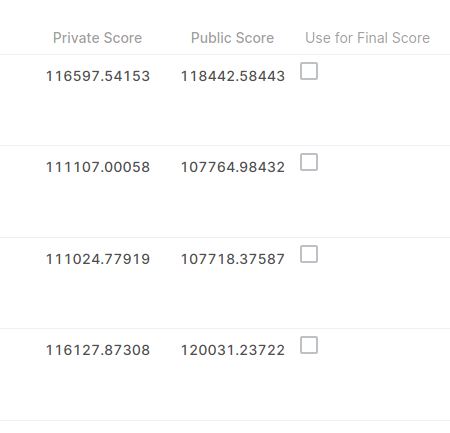   
   
   
### 5. **자기 다짐**   
이번 노드와 캐글 팀프로젝트까지 많은 것을 경험하고 배울 수 있어 좋았다. 특히 캐글 프로젝트는 지금까지 배웠던 모든 것을 내 스스로가 직접 이요해볼 수 있는 좋은 기회였다고 생각한다. 결과는 좋지 못했지만 앞으로 어떻게 공부를 해야하는지 느낄 수 있었고 노드를 만드신 분들이 얼마나 대단하신 분들인가를 많이 느꼈다.


   